In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

import os
import random

import numpy as np
import pandas as pd

import matplotlib

matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch.nn.functional as F


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
# Set random seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [4]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)


unlabeled_scene_index_shuf = unlabeled_scene_index
random.shuffle(unlabeled_scene_index_shuf)

# split trian/val datasets
train_unlabeled_scene_index = unlabeled_scene_index_shuf[:-25]
val_unlabeled_scene_index = unlabeled_scene_index_shuf[-25:]

In [5]:
def my_collate_fn(batch):
    imgs = []
    for x in batch:
        front = torch.cat( (torch.tensor( x[0] ), torch.tensor( x[1] ), torch.tensor( x[2] )), 2 )
        back = torch.cat( (torch.tensor( x[3] ), torch.tensor( x[4] ), torch.tensor( x[5] )), 2 )
        curr_image = torch.cat( (front, back), 1)
        #curr_image = torch.cat( (front, back), 1).transpose(2,1).flip(2)
        trans = transforms.Compose([transforms.ToPILImage(), 
                                    transforms.Resize((800,800)),
                                    transforms.ToTensor()])
        comb = trans(curr_image)
        imgs.append(comb)    
    return torch.stack(imgs)

In [6]:
transform = torchvision.transforms.ToTensor()

# train loader
unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, 
                                      scene_index=train_unlabeled_scene_index, 
                                      first_dim='sample', 
                                      transform=transform)

train_loader = torch.utils.data.DataLoader(unlabeled_trainset, 
                                           batch_size=2,
                                           shuffle=True, 
                                           num_workers=2,
                                           collate_fn=my_collate_fn)

# val loader
unlabeled_valset = UnlabeledDataset(image_folder=image_folder, 
                                    scene_index=val_unlabeled_scene_index, 
                                    first_dim='sample', 
                                    transform=transform)

val_loader = torch.utils.data.DataLoader(unlabeled_valset, 
                                         batch_size=2, 
                                         shuffle=True, 
                                         num_workers=2,
                                         collate_fn=my_collate_fn)

In [7]:
# [batch_size, 6, 3, H, W]
sample = iter(train_loader).next()
sample.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/Library/Framewor

torch.Size([2, 3, 800, 800])

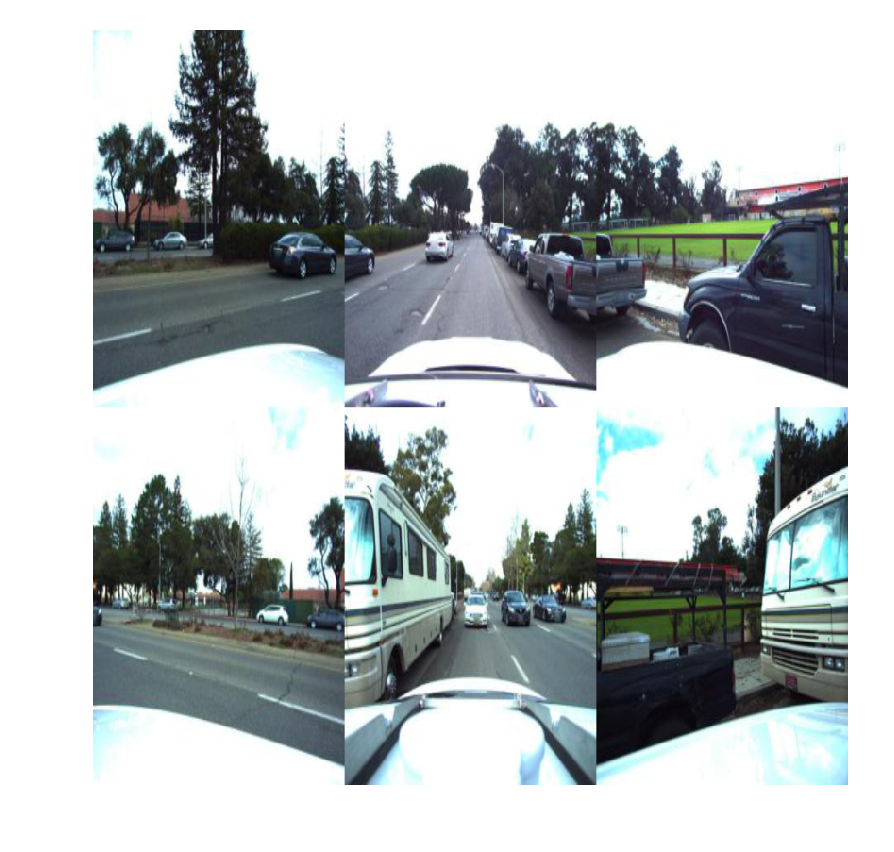

In [8]:
plt.imshow(sample[0].numpy().transpose(1, 2, 0))
plt.axis('off');

In [10]:
# Defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
d = 30

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(800 * 800 *3, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 800 * 800 * 3),
            nn.Tanh(),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()

for param in model.parameters():
    param.requires_grad = True

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [ ]:
# Training and testing the VAE

epochs = 10
# codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training

    model.train()

    train_loss = 0
    for i, sample in enumerate(train_loader):

        sample = sample.to(device)
        sample = sample.view(sample.size(0), -1)
        # ===================forward=====================
        x_hat = model(sample)

        loss = criterion(sample, x_hat)
        train_loss += loss.item()

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        if i % 1000  == 0:
            avg_loss = float(train_loss / (i+1))
            print('Epoch: {} | Avg Loss: {}'.format(epoch, avg_loss))
            
    avg_loss = float(train_loss / len(train_loader))
    print('Trained Epoch {} | Total Avg Loss: {}'.format(epoch, avg_loss))
    
    # Testing
    
    with torch.no_grad():
        model.eval()
        val_loss = 0
        for i,sample in enumerate(val_loader):

            sample = sample.to(device)
            sample = sample.view(sample.size(0), -1)
            # ===================forward=====================

            x_hat = model(sample)

            loss = criterion(sample, x_hat)
            val_loss += loss.item()

            # ===================log========================
            if i % 1000  == 0:
                avg_loss = float(val_loss / (i+1))
                print('Epoch: {} | Avg Loss: {}'.format(epoch, avg_loss))
            
        avg_loss = float(val_loss / len(val_loader))
        print('Trained Epoch {} | Total Avg Loss: {}'.format(epoch, avg_loss))
    
        global best_val_loss
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            torch.save(model.state_dict(), 'best_AE_simple.pt')

In [13]:
### show some example ###
model = Autoencoder().to(device)
model.load_state_dict(torch.load('pt_files/best_AE_pretrain_01.pt', map_location=device))
print(model.state_dict())

OrderedDict([('encoder.0.weight', tensor([[-0.0060, -0.0056, -0.0066,  ..., -0.0058, -0.0056, -0.0055],
        [-0.0053, -0.0060, -0.0056,  ..., -0.0057, -0.0064, -0.0053],
        [-0.0061, -0.0055, -0.0054,  ..., -0.0065, -0.0054, -0.0061],
        ...,
        [ 0.0056,  0.0061,  0.0058,  ...,  0.0064,  0.0058,  0.0056],
        [ 0.0060,  0.0066,  0.0066,  ...,  0.0058,  0.0055,  0.0058],
        [-0.0057, -0.0055, -0.0054,  ..., -0.0059, -0.0056, -0.0062]])), ('encoder.0.bias', tensor([-0.0061, -0.0065, -0.0054,  0.0067, -0.0056, -0.0056, -0.0056, -0.0064,
         0.0057, -0.0062,  0.0061,  0.0056, -0.0064,  0.0053,  0.0056,  0.0066,
        -0.0067, -0.0059, -0.0059, -0.0057,  0.0067, -0.0055, -0.0054,  0.0063,
         0.0056, -0.0055, -0.0064,  0.0067,  0.0055, -0.0057])), ('decoder.0.weight', tensor([[ 0.1185, -0.1887, -0.1884,  ..., -0.1244, -0.0151,  0.1124],
        [ 0.1524,  0.0509,  0.0931,  ...,  0.1717,  0.1249, -0.1786],
        [-0.0301,  0.1983,  0.1531,  ...,  0.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/Library/Framewor

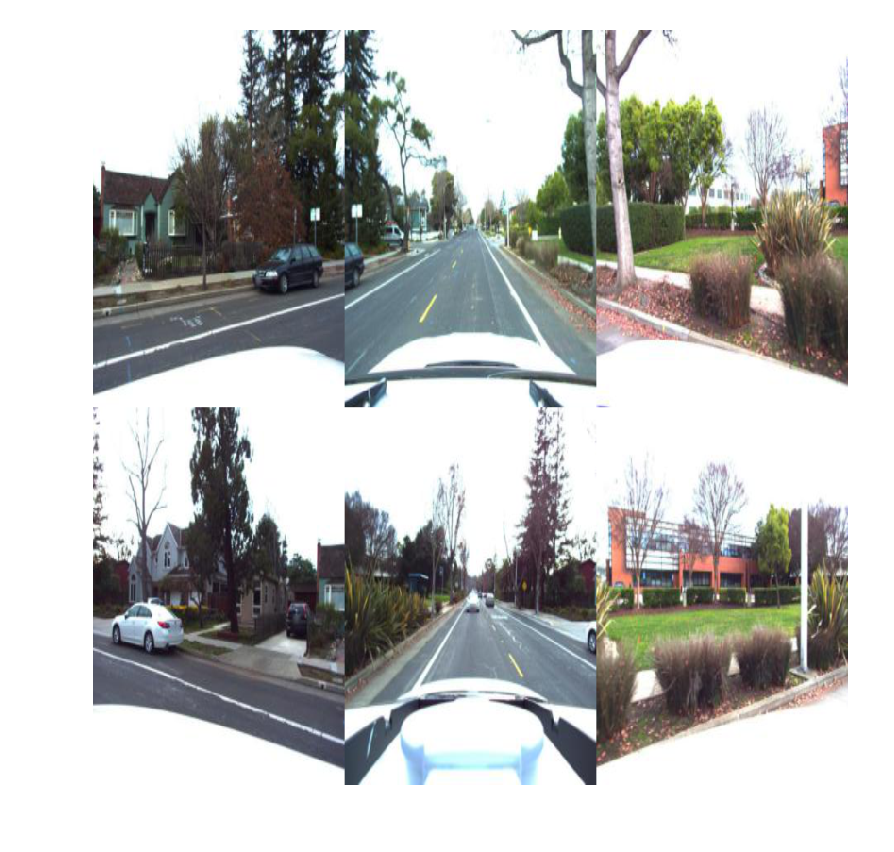

In [44]:
sample = iter(val_loader).next()
plt.imshow(sample[0].numpy().transpose(1, 2, 0))
plt.axis('off');

torch.Size([2, 3, 800, 800])
torch.Size([2, 1920000])
torch.Size([2, 1920000])
torch.Size([6, 800, 800])


(-0.5, 799.5, 799.5, -0.5)

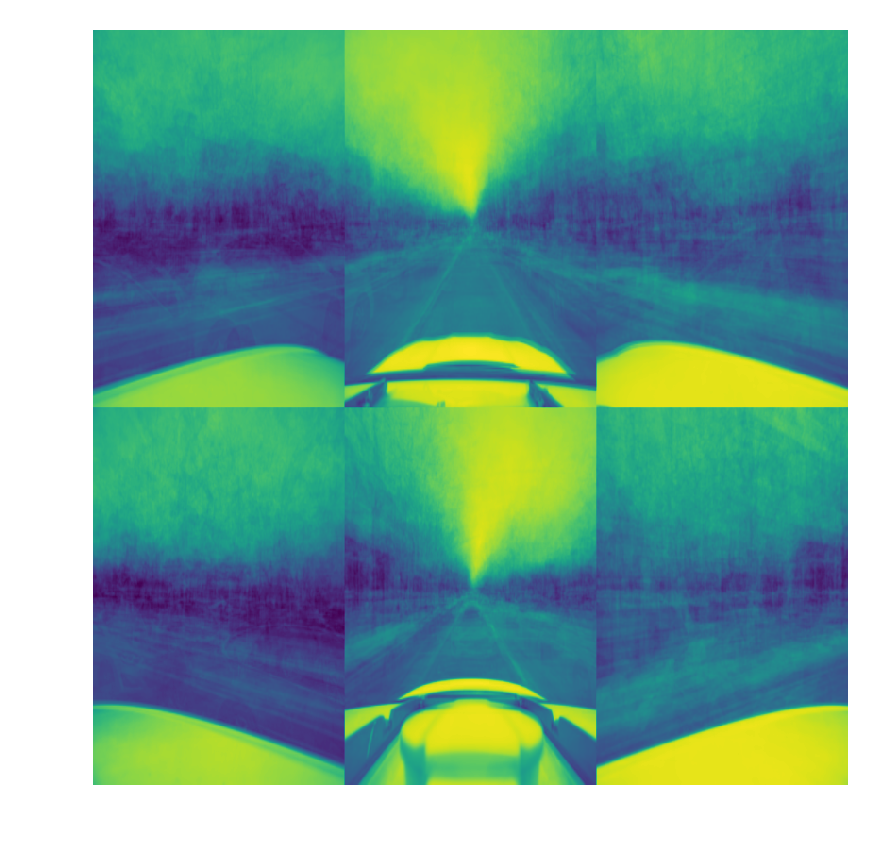

In [45]:
print(sample.shape)
sample = sample.to(device)
sample = sample.view(sample.size(0), -1)

print(sample.shape)
out = model(sample)
print(out.shape)
out_pic = out.data.cpu().view(-1, 800, 800)
print(out_pic.shape)

plt.imshow(out_pic[0])
plt.axis('off')

In [23]:

# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 800, 800)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 800, 800)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

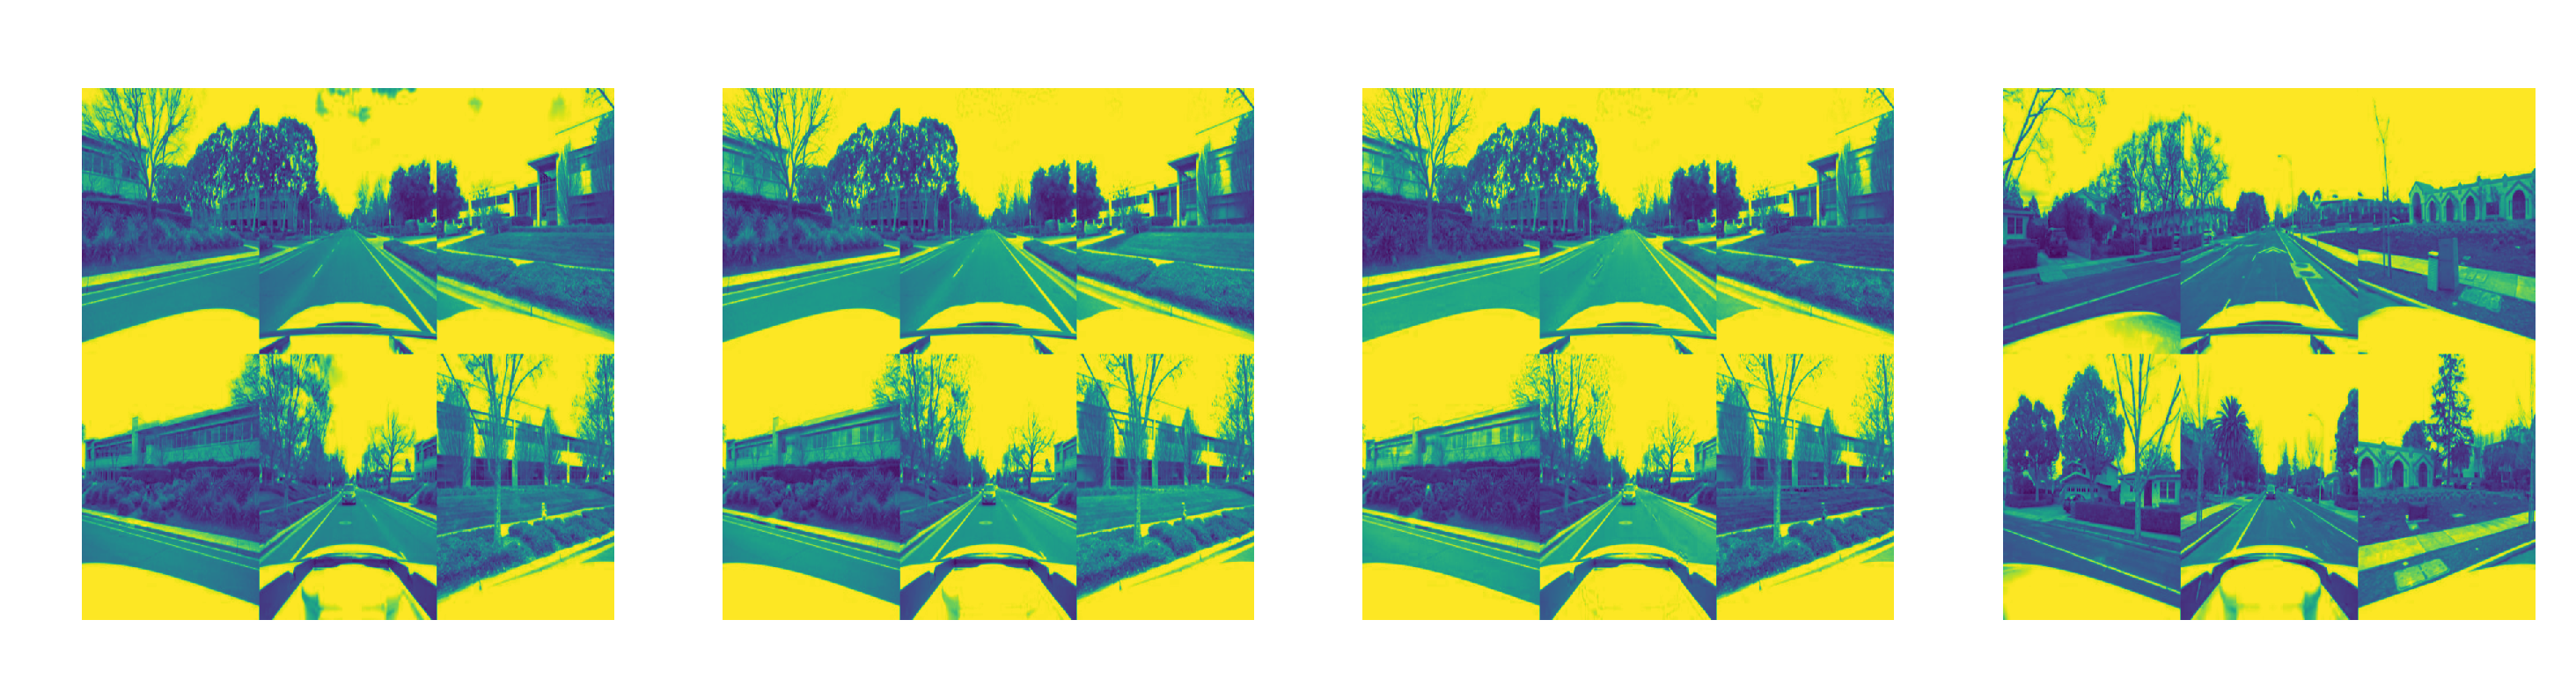

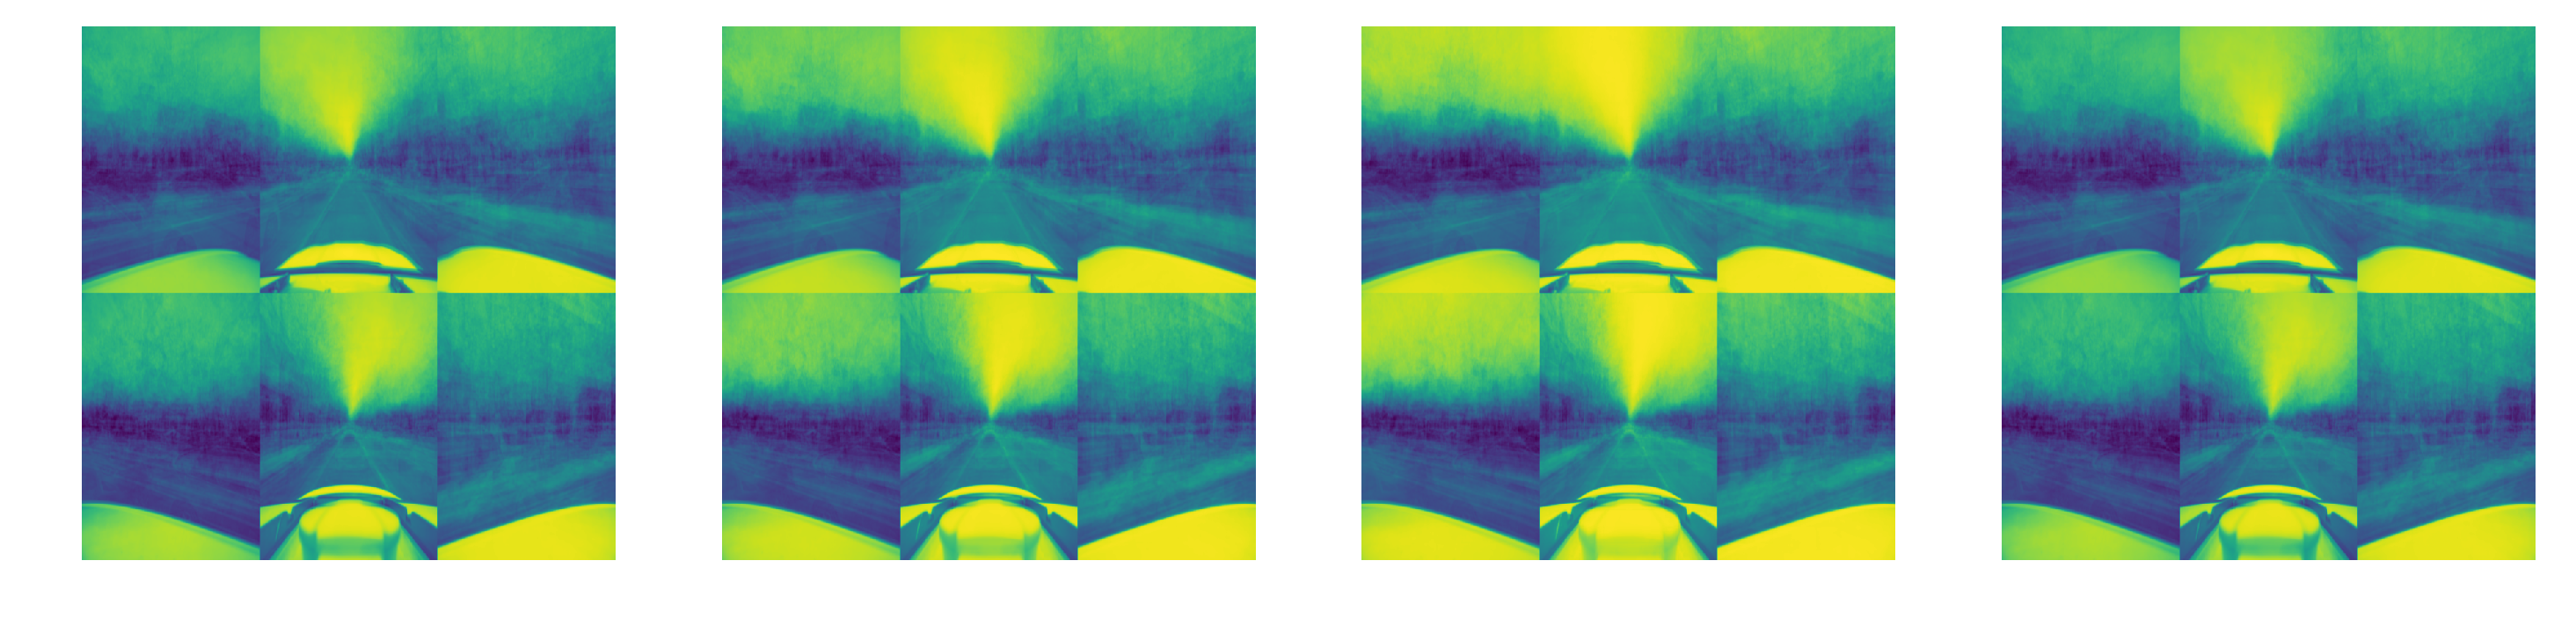

In [26]:
pred = model(sample)

display_images(sample.to(device), pred, label='test')